### Brain Tumor Dataset from Kaggle 
Link: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset<br>
_________________
<table align="left">
    <tr>
        <th>Com tumor</th>
        <th>Sem tumor</th>
        <th>Total</th>
    </tr>
    <tr>
        <td style="text-align: center;">2513</td>
        <td style="text-align: center;">2087</td>
        <td style="text-align: center;">4600</td>
    </tr>
</table>

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from progressbar import AnimatedMarker, Bar, ETA, FileTransferSpeed, Percentage, ProgressBar
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

### Carregamento dos Dados

In [4]:
datadir = "C:\\Users\\robso\\CNN Brain Tumor\\Brain Tumor Data Set\\"
categories = ['Healthy', 'Brain Tumor']
x = []
y = []

for category in categories:
    path = os.path.join(datadir, category)
    
    for i in os.listdir(path):
        image = cv2.imread(os.path.join(path, i), cv2.IMREAD_GRAYSCALE)
        image = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        x.append(image)
        y.append(categories.index(category))

### Divisão do Conjunto de Dados

In [5]:
x = np.array(x)
y = np.array(y)

x2, x_test, y2, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size=0.2, shuffle=True, stratify=y2)

inputs = np.concatenate((x_train, x_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

### Arquitetura e Treinamento da CNN

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

kfold = KFold(n_splits=5, shuffle=True)
acc_fold = []
loss_fold = []

for train, test in kfold.split(inputs, targets):
    model = Sequential()

    model.add(Flatten(input_shape=(128,128,3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    
    results = model.fit(inputs[train], targets[train], epochs=10, validation_data=(inputs[test], targets[test]))
    score, acc = model.evaluate(inputs[test], targets[test], verbose=0)
    print('-----------------------------------------------')
    print(f'Score: {model.metrics_names[0]} de {score}; {model.metrics_names[1]} de {acc*100}%')
    acc_fold.append(acc*100)
    loss_fold.append(score)

print('\nMédia de todos folds')
print('-----------------------------------------------')
print(f'Acurácia: {np.mean(acc_fold)}% (+/- {np.median(acc_fold)}%)')
print(f'Loss: {np.mean(score)}%')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               6291584   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
104/104 [==============================] - 10s 87ms/step - loss: 1.2996 - accuracy: 0.6098 - val_loss: 0.5415 - val_accuracy: 0.7343
Epoch 2/10
104/104 [==============================] - 5s 47ms/step - loss: 0.5164 - accuracy: 0.73

Epoch 1/10
104/104 [==============================] - 7s 56ms/step - loss: 1.3419 - accuracy: 0.5728 - val_loss: 0.5266 - val_accuracy: 0.7717
Epoch 2/10
104/104 [==============================] - 5s 49ms/step - loss: 0.5816 - accuracy: 0.6992 - val_loss: 0.4878 - val_accuracy: 0.7862
Epoch 3/10
104/104 [==============================] - 5s 48ms/step - loss: 0.5135 - accuracy: 0.7597 - val_loss: 0.4120 - val_accuracy: 0.8370
Epoch 4/10
104/104 [==============================] - 5s 47ms/step - loss: 0.4378 - accuracy: 0.8111 - val_loss: 0.3981 - val_accuracy: 0.8406
Epoch 5/10
104/104 [==============================] - 5s 48ms/step - loss: 0.3933 - accuracy: 0.8269 - val_loss: 0.3463 - val_accuracy: 0.8454
Epoch 6/10
104/104 [==============================] - 5s 49ms/step - loss: 0.3319 - accuracy: 0.8702 - val_loss: 0.3148 - val_accuracy: 0.8937
Epoch 7/10
104/104 [==============================] - 5s 46ms/step - loss: 0.2875 - accuracy: 0.8965 - val_loss: 0.2876 - val_accuracy: 0.8804

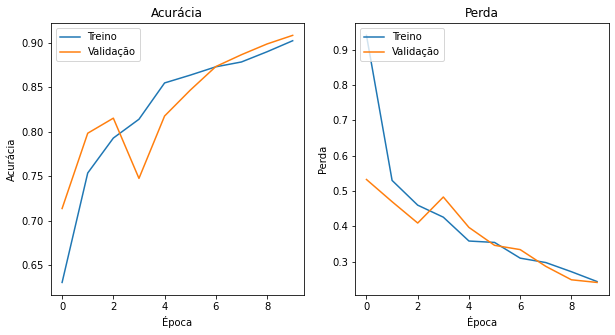

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.subplot(122)
plt.title('Perda')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.show()

### Teste da CNN

Métrica de avaliação		Resultado
---------------------------------------------
Acurácia:		 90.65217391304348 %
Precisão:		 88.23529411764706 %
Sensibilidade:		 95.61752988047809 %
Especificidade:		 84.68899521531101 %


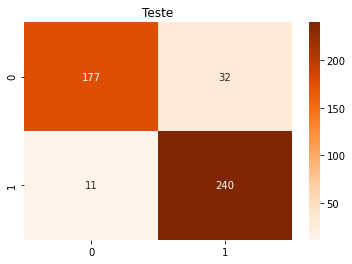

In [11]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

cmat=confusion_matrix(y_test,y_pred,labels=[0,1])
cm_df = pd.DataFrame(cmat)

tp = cmat[1][1]
fp = cmat[0][1]
tn = cmat[0][0]
fn = cmat[1][0]

accuracy = ((tp+tn)*100)/np.sum(cmat)
precision = (tp*100)/(tp+fp)
sensibility = (tp*100/(tp+fn))
specificity = (tn*100)/(fp+tn)

print('Métrica de avaliação\t\tResultado')
print('---------------------------------------------')
print('Acurácia:\t\t',accuracy,"%")
print('Precisão:\t\t',precision,"%")

print('Sensibilidade:\t\t',sensibility,"%")
print('Especificidade:\t\t',specificity,"%")
                   
plt.title('Teste')
sns.heatmap(cm_df, annot=True, fmt="d", cmap=plt.cm.Oranges)
plt.show()

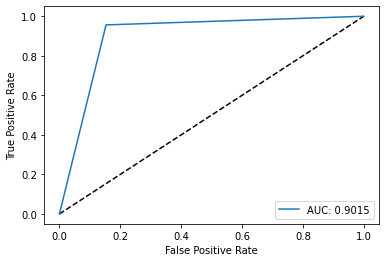

In [12]:
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(y_test, y_pred)
auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_cnn, tpr_cnn, label='AUC: {:.4f}'.format(auc_cnn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()